# Generative Adversariar Networks

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from keras import layers
from keras import ops

shape of set (70000, 28, 28), (70000,), total data 70000, pixels 28


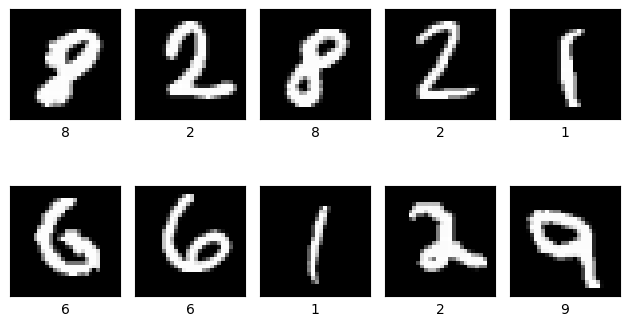

In [2]:
def create_data_sets(n = None):

    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train, x_test = x_train/255, x_test/255
    
    x = np.concatenate((x_train, x_test))
    y = np.concatenate((y_train, y_test))
    
    permutation = np.random.permutation(x.shape[0])
    x = x[permutation]
    y = y[permutation]
    
    if n == None: 
        return x, y
    
    return x[:n], y[:n]

x, y = create_data_sets()
n_total, pixels = x.shape[:2]
print(f'shape of set {x.shape}, {y.shape}, total data {n_total}, pixels {pixels}')

# plot some training examples
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(x[i],
               cmap= 'gray'
               )
    plt.xlabel(f'{y[i]}')
    # plt.axis('off')
    plt.xticks(())
    plt.yticks(())
    plt.tight_layout()

In [4]:
# define a really simple descriminator architecture
discriminator = keras.Sequential(
    [
        keras.Input(shape=(pixels**2,)),
        layers.Dense(128, activation="relu"),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()

# complex architecture from keras documentation
# discriminator = keras.Sequential(
#     [
#         keras.Input(shape=(pixels, pixels, 1)),
#         layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
#         layers.LeakyReLU(negative_slope=0.2),
#         layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
#         layers.LeakyReLU(negative_slope=0.2),
#         layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
#         layers.LeakyReLU(negative_slope=0.2),
#         layers.Flatten(),
#         layers.Dropout(0.2),
#         layers.Dense(1, activation="sigmoid"),
#     ],
#     name="discriminator",
# )
# discriminator.summary()

Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 100,609 (393.00 KB)

 Trainable params: 100,609 (393.00 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# simple generator architecture 
latent_dim = 10

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(14**2, activation='sigmoid'),
        layers.Dense(pixels**2, activation='sigmoid'),
    ],
    name="generator",
)
generator.summary()

# complex generator architecture from keras documentation
# latent_dim = 128

# generator = keras.Sequential(
#     [
#         keras.Input(shape=(latent_dim,)),
#         layers.Dense(8 * 8 * 128),
#         layers.Reshape((8, 8, 128)),
#         layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
#         layers.LeakyReLU(negative_slope=0.2),
#         layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
#         layers.LeakyReLU(negative_slope=0.2),
#         layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
#         layers.LeakyReLU(negative_slope=0.2),
#         layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
#     ],
#     name="generator",
# )
# generator.summary()

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 196)            │         2,156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 784)            │       154,448 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 156,604 (611.73 KB)

 Trainable params: 156,604 (611.73 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# code from keras documentation
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.seed_generator = keras.random.SeedGenerator(1337)

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = ops.shape(real_images)[0]
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim), seed=self.seed_generator
        )

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = ops.concatenate([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = ops.concatenate(
            [ops.ones((batch_size, 1)), ops.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim), seed=self.seed_generator
        )

        # Assemble labels that say "all real images"
        misleading_labels = ops.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

In [8]:
gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    x.reshape(n_total, -1), 
    epochs=20, 
)

Epoch 1/20
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - d_loss: 0.1706 - g_loss: 2.6714
Epoch 2/20
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - d_loss: 0.1637 - g_loss: 2.0256
Epoch 3/20
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - d_loss: 0.0479 - g_loss: 4.6910
Epoch 4/20
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - d_loss: 0.0311 - g_loss: 5.2639
Epoch 5/20
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - d_loss: 0.0410 - g_loss: 4.9558
Epoch 6/20
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - d_loss: 0.0659 - g_loss: 4.2876
Epoch 7/20
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - d_loss: 0.0433 - g_loss: 5.3587
Epoch 8/20
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - d_loss: 0.0398 - g_loss: 5.5223
Epoch 9/20
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - d_loss: 0.0404 - g_loss: 5.8417
Epoch 10/20
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - d_loss: 0.0283 - g_loss: 6.4991
Epoch 11/20
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - d_loss: 0.0276 - g_loss: 6.5626
Epoch 12/20
2188/21

some original images


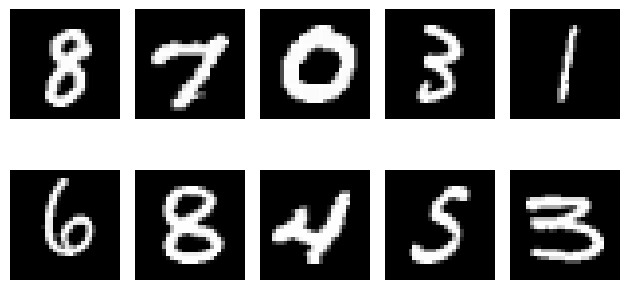

In [9]:
print('some original images')
img = x[np.random.randint(0, n_total, 10)]
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(img[i],
               cmap= 'gray'
               )
    plt.axis('off')
    plt.tight_layout()

some generated images


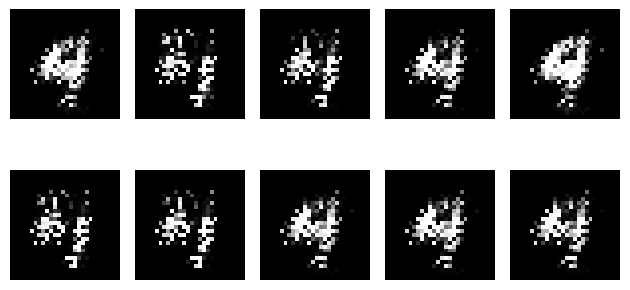

In [10]:
# generate some images
n_gen_img = 10
z = keras.random.normal(shape=(n_gen_img, latent_dim))
x_generated = generator(z)
x_generated = x_generated.numpy().reshape(n_gen_img, pixels, pixels)

print('some generated images')
for i in range(n_gen_img):
    plt.subplot(2, 5, i+1)
    plt.imshow(x_generated[i],
               cmap= 'gray'
               )
    plt.axis('off')
    plt.tight_layout()